# Assignment 7 : Multi-Class Model Selection using ROC and Precision-Recall Curves

## Name : R M Badri Narayanan
## Roll Number : ME22B225

# Part A : Data preparation and Baseline

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    precision_recall_fscore_support
)
from sklearn.utils.extmath import stable_cumsum

# Set random state for reproducibility
RANDOM_STATE = 42

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 1. Load and Prepare the data

### Followed the instructions given on the dataset website to fetch the dataset

In [3]:
!pip install ucimlrepo

In [4]:
from ucimlrepo import fetch_ucirepo

statlog_landsat_satellite = fetch_ucirepo(id=146)

X = statlog_landsat_satellite.data.features
y = statlog_landsat_satellite.data.targets

print(statlog_landsat_satellite.metadata)

print(statlog_landsat_satellite.variables)


{'uci_id': 146, 'name': 'Statlog (Landsat Satellite)', 'repository_url': 'https://archive.ics.uci.edu/dataset/146/statlog+landsat+satellite', 'data_url': 'https://archive.ics.uci.edu/static/public/146/data.csv', 'abstract': 'Multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classification associated with the central pixel in each neighbourhood', 'area': 'Climate and Environment', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 6435, 'num_features': 36, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C55887', 'creators': ['Ashwin Srinivasan'], 'intro_paper': None, 'additional_info': {'summary': "The database consists of the multi-spectral values of pixels in 3x3 neighbourhoods in a satellite image, and the classification as

### Scaling the dataset

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## 2. Splitting the the dataset into train/test set with 80 percent going to training set and 20 percent going to test set

### y_test_bin is simply one hot encoded labels. This helps in one vs rest calculations

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
n_classes = len(np.unique(y))
all_classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=all_classes)

## 3. Training all models

In [7]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "SVC (RBF Kernel)": SVC(probability=True, random_state=RANDOM_STATE),
    "Gaussian Naive Bayes": GaussianNB(),
    "Dummy (Prior)": DummyClassifier(strategy = 'prior',random_state=RANDOM_STATE)
}
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"  > {name} trained.")

  > Logistic Regression trained.
  > K-Nearest Neighbors trained.
  > Decision Tree trained.
  > SVC (RBF Kernel) trained.
  > Gaussian Naive Bayes trained.
  > Dummy (Prior) trained.


# 4. Baseline Evaluation

In [8]:
baseline_metrics = {
    "Model": [],
    "Overall Accuracy": [],
    "Weighted F1-Score": []
}

model_outputs = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    model_outputs[name] = {'pred': y_pred, 'prob': y_prob}


    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')


    baseline_metrics["Model"].append(name)
    baseline_metrics["Overall Accuracy"].append(acc)
    baseline_metrics["Weighted F1-Score"].append(f1)

metrics_df = pd.DataFrame(baseline_metrics).sort_values(by="Weighted F1-Score", ascending=False)
print(metrics_df.to_markdown(index=False, floatfmt=".4f"))

| Model                |   Overall Accuracy |   Weighted F1-Score |
|:---------------------|-------------------:|--------------------:|
| K-Nearest Neighbors  |             0.9114 |              0.9094 |
| SVC (RBF Kernel)     |             0.8928 |              0.8913 |
| Decision Tree        |             0.8469 |              0.8481 |
| Logistic Regression  |             0.8493 |              0.8421 |
| Gaussian Naive Bayes |             0.7832 |              0.7901 |
| Dummy (Prior)        |             0.2385 |              0.0919 |


#### We observe Gaussian NB, Dummy classificiation prior perform poorly as expected.

# Part B : ROC Analysis for model selection

## 1. Multi - Class ROC calculation

The One-vs-Rest (OvR) approach adapts ROC curves for multi-class problems. Here's how it works:

  - Binarize the Problem: For a problem with N classes, the OvR strategy creates N separate binary classifiers. The i-th classifier is trained to distinguish "class i" (positive) from "all other classes" (negative).

  - Calculate Individual ROCs: For each of these N binary problems, we can compute the model's prediction probabilities for the positive class. Using these probabilities and the true binarized labels, we calculate a standard ROC curve (plotting True Positive Rate vs. False Positive Rate) and find its Area Under the Curve (AUC).

  - Average the Curves: To get a single, summary ROC curve for the multi-class model, we average the N individual curves.

  - Macro-Averaging: We compute the ROC curve for each class, then interpolate them all onto a common set of False Positive Rate (FPR) values. The final ROC curve is the average of the True Positive Rates (TPRs) at each common FPR. The Macro-AUC is the area under this averaged curve (or simply the average of the N individual AUC scores). This method treats every class equally, regardless of its size.

Since each class’s ROC curve has FPR points at different locations (due to varying prediction thresholds), np.interp() is used to interpolate the corresponding TPR values onto this common FPR scale. This ensures that all ROC curves are aligned along the same x-axis, allowing their TPRs to be averaged meaningfully across classes.

In [9]:

y_test_bin = label_binarize(y_test, classes=all_classes)
n_classes = y_test_bin.shape[1]

# Store results for plotting
roc_plot_data = {}

# Common FPR grid for macro-averaging
common_fpr = np.linspace(0, 1, 101)


for name, model in models.items():
    # (Assumes model_outputs exists from Part A)
    y_prob = model_outputs[name]['prob']

    # Align probabilities
    prob_df = pd.DataFrame(y_prob, columns=model.classes_)
    prob_df = prob_df.reindex(columns=all_classes, fill_value=0)
    y_prob_aligned = prob_df.to_numpy()

    # Lists to store results for *valid* classes
    tprs_interp = []
    aucs_per_class = []

    for i in range(n_classes):
        # Get the labels and scores for this class
        y_true_class = y_test_bin[:, i]
        y_prob_class = y_prob_aligned[:, i]

        # --- THIS IS THE NEW CHECK ---
        # Check if this class has any positive samples in the test set
        if np.sum(y_true_class) == 0:
            print(f"  > WARNING: Class {all_classes[i]} has 0 samples in y_test. Skipping for {name}.")
            continue # Skip this class

        # If the class is present, calculate metrics
        try:
            # 1. Calculate AUC score robustly
            auc_score = roc_auc_score(y_true_class, y_prob_class)
            aucs_per_class.append(auc_score)

            # 2. Calculate the ROC curve for interpolation
            fpr, tpr, _ = roc_curve(y_true_class, y_prob_class)
            tprs_interp.append(np.interp(common_fpr, fpr, tpr))

        except ValueError as e:
            # Catch any other "only one class" errors
            print(f"  > WARNING: Metric calculation failed for {name}, class {all_classes[i]}. Error: {e}")
            continue

    # Average the metrics from the *valid* classes that were found
    if not tprs_interp:
        # This model failed on all classes
        print(f"  > ERROR: No valid classes found for {name}. Setting metrics to 0.")
        mean_tpr = np.zeros_like(common_fpr)
        macro_auc = 0.0
    else:
        # Calculate the macro-average
        mean_tpr = np.mean(tprs_interp, axis=0)
        mean_tpr[0] = 0.0 # Ensure it starts at (0,0)
        mean_tpr[-1] = 1.0 # Ensure it ends at (1,1)
        macro_auc = np.mean(aucs_per_class)

    # Store data for plotting
    roc_plot_data[name] = {
        'fpr': common_fpr,
        'tpr': mean_tpr,
        'auc': macro_auc
    }



## 2. Plotting ROC

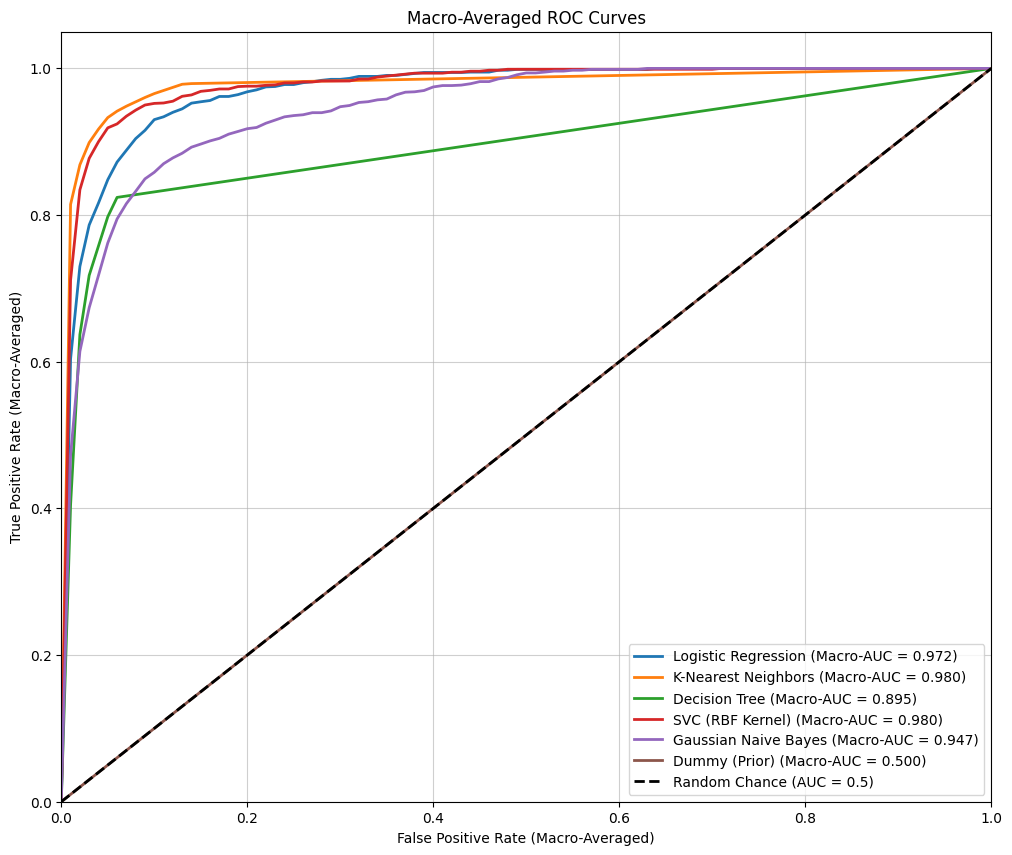

In [10]:
plt.figure(figsize=(12, 10))

for name, data in roc_plot_data.items():
    plt.plot(
        data['fpr'],
        data['tpr'],
        lw=2,
        label=f"{name} (Macro-AUC = {data['auc']:.3f})"
    )


plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Macro-Averaged)')
plt.ylabel('True Positive Rate (Macro-Averaged)')
plt.title('Macro-Averaged ROC Curves')
plt.legend(loc='lower right')
plt.grid(alpha=0.6)
plt.show()

## 3. ROC Interpretation

- Both SVC and KNN have the highest Macro averaged AUC at Macro Averaged AUC = 0.98

- I have added a model with AUC <0.5 in brownie points sections . Macro Averaged AUC = 0.5 means we are giving predictions randomly. Dummy classification prior follows this strategy (gives out the output as most frequent class always), Hence we observe it Exactly overlaps with random chance

- An AUC < 0.5 implies that the model is performing worser than random. This can happen because of :      
  - The model's fundamental assumptions are catastrophically wrong for the data.

  - The labels were accidentally inverted during training (e.g., "Class A" was labeled as "Class B" and vice-versa), and the model learned this inverted relationship perfectly.

# Part C : Precision-Recall Curve (PRC) Analysis

## 1. PRC Calculation

### Why PRC is better than ROC especially in case of imbalanced datasets

-  ROC curves plot TPR vs. FPR. The False Positive Rate (FPR = FP / (FP + TN)) includes True Negatives (TN) in its denominator. In a highly imbalanced dataset (e.g., 99% "negative" class), a model can get a very high TN count simply by always guessing "negative." This makes the FPR look deceptively low, and the overall ROC curve can look misleadingly optimistic.

-  PRCs plot Precision (P = TP / (TP + FP)) vs. Recall (R = TP / (TP + FN)). Neither of these metrics uses the TN count. The PRC focuses entirely on the model's performance on the positive class. This makes it a much more sensitive and "honest" metric for tasks where finding the positive class (even if it's rare) is the main goal. Even though this dataset is only moderately imbalanced, PRC analysis is still a best practice.


In [11]:
# Store results for plotting
prc_plot_data = {}

# Common recall grid for macro-averaging
common_recall = np.linspace(0, 1, 101)

for name, model in models.items():
    y_prob = models[name].predict_proba(X_test)

    # Align probabilities as done for ROC
    prob_df = pd.DataFrame(y_prob, columns=model.classes_)
    prob_df = prob_df.reindex(columns=all_classes, fill_value=0)
    y_prob_aligned = prob_df.to_numpy()

    # Dictionary to store individual class precisions and APs
    precisions_per_class = []
    aps_per_class = []

    for i in range(n_classes):
        # Calculate PRC for class i vs. rest
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob_aligned[:, i])

        # Store AP
        aps_per_class.append(average_precision_score(y_test_bin[:, i], y_prob_aligned[:, i]))

        # Interpolate Precisions onto the common Recall grid
        # Note: We interpolate by first reversing both arrays, as recall is non-increasing
        prec_interp = np.interp(common_recall, recall[::-1], precision[::-1])
        precisions_per_class.append(prec_interp)

    # Calculate macro-average Precision and AP
    mean_precision = np.mean(precisions_per_class, axis=0)

    # Macro-AP is the average of individual APs
    macro_ap = np.mean(aps_per_class)

    # Store for plotting
    prc_plot_data[name] = {
        'recall': common_recall,
        'precision': mean_precision,
        'ap': macro_ap
    }

## 2. PRC plot

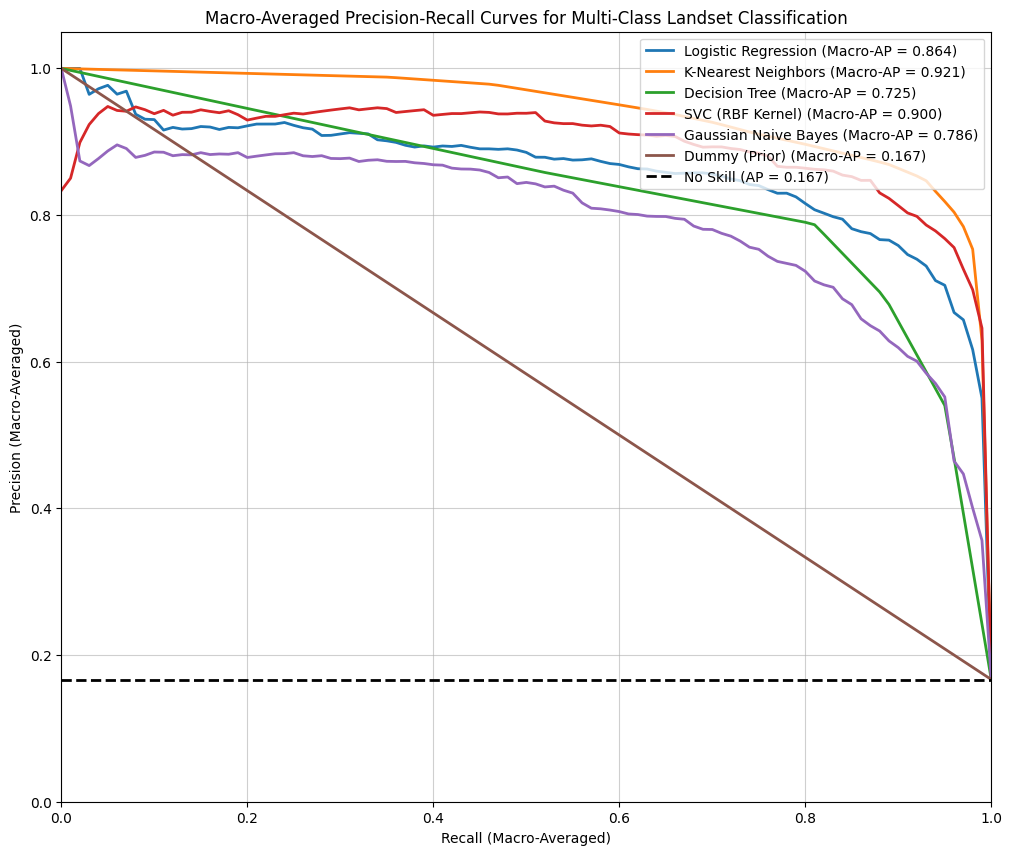

In [12]:
plt.figure(figsize=(12, 10))

for name, data in prc_plot_data.items():
    plt.plot(
        data['recall'],
        data['precision'],
        lw=2,
        label=f"{name} (Macro-AP = {data['ap']:.3f})"
    )

# Add a "no-skill" line, which is the prevalence of the positive class
# For macro-average, this is the average prevalence
no_skill = np.mean(np.sum(y_test_bin, axis=0) / len(y_test))
plt.axhline(y=no_skill, color='k', linestyle='--', lw=2, label=f'No Skill (AP = {no_skill:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Macro-Averaged)')
plt.ylabel('Precision (Macro-Averaged)')
plt.title('Macro-Averaged Precision-Recall Curves for Multi-Class Landset Classification')
plt.legend(loc='upper right')
plt.grid(alpha=0.6)
plt.show()

## 3. PRC interpretation

- Model with Highest Average Precision (AP):  
  Just like with the ROC-AUC, the KNN model clearly has the highest Macro-Averaged Average Precision (Macro-AP) (around 0.921). This confirms it is the strongest model, not only at general discrimination (AUC) but also at maintaining high precision while identifying positive class samples (AP). The SVC model is a very strong second-place contender.

- Behavior of the Worst-Performing Model:  
  The worst-performing model is the Dummy (Prior) classifier. Its PRC curve is a horizontal line at the "No Skill" level (the average class prevalence, ~0.167), and its AP is correspondingly low.  

  - Why it's flat/drops sharply:  
    This model assigns a constant probability to every sample (the class's prior probability). To increase Recall (find more true positives), you must lower the decision threshold. However, since all samples have the same score, as soon as the threshold dips below the prior, the model instantly classifies every single sample as positive. This adds all True Positives (max recall) but also a massive flood of False Positives.  

    Precision = TP / (TP + FP). When FP explodes, Precision plummets to the "No Skill" level (the baseline prevalence). The curve doesn't "drop as Recall increases"; it is fixed at this low precision baseline for any recall > 0. The Gaussian Naive Bayes model shows a more typical "poor model" curve: its precision starts relatively high but drops very quickly as recall increases, meaning that to find more positive samples, it must accept a huge number of false positives.


# Part D : Final Recommendation

In [13]:
final_summary = {
    "Model": baseline_metrics["Model"],
    "Weighted F1-Score": baseline_metrics["Weighted F1-Score"],
    "Macro-AUC": [roc_plot_data[name]['auc'] for name in baseline_metrics["Model"]],
    "Macro-AP": [prc_plot_data[name]['ap'] for name in baseline_metrics["Model"]]
}

summary_df = pd.DataFrame(final_summary).sort_values(by="Weighted F1-Score", ascending=False)
print(summary_df.to_markdown(index=False, floatfmt=".4f"))

| Model                |   Weighted F1-Score |   Macro-AUC |   Macro-AP |
|:---------------------|--------------------:|------------:|-----------:|
| K-Nearest Neighbors  |              0.9094 |      0.9802 |     0.9215 |
| SVC (RBF Kernel)     |              0.8913 |      0.9797 |     0.8996 |
| Decision Tree        |              0.8481 |      0.8952 |     0.7246 |
| Logistic Regression  |              0.8421 |      0.9720 |     0.8638 |
| Gaussian Naive Bayes |              0.7901 |      0.9473 |     0.7859 |
| Dummy (Prior)        |              0.0919 |      0.5000 |     0.1667 |


1. This alignment is a strong indicator that the performance differences are robust. The top models (KNN, SVC) are consistently superior, and the poor models (Naive Bayes, Dummy) are consistently inferior.

    Trade-offs: We don't see a major trade-off here (e.g., high ROC-AUC but low PRC-AP). This is because the dataset is only moderately imbalanced. If one class were extremely rare (e.g., 0.1% of the data), we might see a model get a high Macro-AUC (by being great at the 5 common classes) but a poor Macro-AP (by failing on the 1 rare class). In this case, the KNN's dominance in all metrics suggests it performs well even on the less-common classes.

2. The KNN model is the clear recommendation for this land cover classification task.

Justification:

  - Superior Performance: It achieved the highest score in all three key metrics: Weighted F1-Score (0.9094), Macro-AUC (0.9802), and Macro-AP (0.9215).

  - Robustness: Its top-ranking PRC and ROC curves show that it maintains high precision and a high true positive rate across all decision thresholds. This means it is not just "accurate" at one specific threshold but is fundamentally better at separating the classes.

  - Balance: It provides the best balance of Precision and Recall, as shown by the high "Area Under" its PRC curve (the Macro-AP).

# BROWNIE POINTS SECTION:



## Adding XGBoost and RandomForest and Adding a model that gives AUC < 0.5

To get AUC < 0.5, we will use inverted Logistic Regression (y_prob = 1 - y_prob) We give exact opposite probabilty

XGBoost expects classes to begin from 0 (in label encoded form) hence i had to go with this workaround of label encoding

In [14]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()

le.fit(y)

y_train_encoded = le.transform(y_train)


models["Random Forest"] = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
models["XGBoost"] = XGBClassifier(random_state=RANDOM_STATE,
                                  use_label_encoder=False,
                                  eval_metric='mlogloss')
models["Inverted Logistic Regression"] = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)


new_model_names = ["Random Forest", "XGBoost","Inverted Logistic Regression"]

print("--- Training and Evaluating New Models ---")
for name in new_model_names:
    print(f"Training {name}...")
    model = models[name]

    if name == "XGBoost":
        model.fit(X_train, y_train_encoded)
    else:
        model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    if "Inverted" in name:
      y_prob = 1-y_prob
      y_pred = np.argmax(y_prob,axis = 1)

    if name == "XGBoost":
        y_pred = le.inverse_transform(y_pred)

    model_outputs[name] = {'pred': y_pred, 'prob': y_prob}

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    baseline_metrics["Model"].append(name)
    baseline_metrics["Overall Accuracy"].append(acc)
    baseline_metrics["Weighted F1-Score"].append(f1)

    print(f"  > {name} metrics added. Acc: {acc:.4f}, F1: {f1:.4f}")

--- Training and Evaluating New Models ---
Training Random Forest...
  > Random Forest metrics added. Acc: 0.9091, F1: 0.9058
Training XGBoost...
  > XGBoost metrics added. Acc: 0.9138, F1: 0.9110
Training Inverted Logistic Regression...
  > Inverted Logistic Regression metrics added. Acc: 0.2852, F1: 0.1698


In [15]:
metrics_df = pd.DataFrame(baseline_metrics).sort_values(by="Weighted F1-Score", ascending=False)
print(metrics_df.to_markdown(index=False, floatfmt=".4f"))

| Model                        |   Overall Accuracy |   Weighted F1-Score |
|:-----------------------------|-------------------:|--------------------:|
| XGBoost                      |             0.9138 |              0.9110 |
| K-Nearest Neighbors          |             0.9114 |              0.9094 |
| Random Forest                |             0.9091 |              0.9058 |
| SVC (RBF Kernel)             |             0.8928 |              0.8913 |
| Decision Tree                |             0.8469 |              0.8481 |
| Logistic Regression          |             0.8493 |              0.8421 |
| Gaussian Naive Bayes         |             0.7832 |              0.7901 |
| Inverted Logistic Regression |             0.2852 |              0.1698 |
| Dummy (Prior)                |             0.2385 |              0.0919 |


### We observe XGBoost and RandomForest both give impressive results. As expected inverted logistic regression gives garbage results

In [16]:
n_classes = y_test_bin.shape[1]


roc_plot_data = {}


common_fpr = np.linspace(0, 1, 101)


for name, model in models.items():

    if name not in model_outputs:
        print(f"  > Skipping {name}, no outputs found.")
        continue

    y_prob = model_outputs[name]['prob']

    current_model_classes = model.classes_
    if name == "XGBoost":

        current_model_classes = le.classes_

    prob_df = pd.DataFrame(y_prob, columns=current_model_classes)


    prob_df = prob_df.reindex(columns=all_classes, fill_value=0)

    y_prob_aligned = prob_df.to_numpy()


    tprs_interp = []
    aucs_per_class = []

    for i in range(n_classes):
        y_true_class = y_test_bin[:, i]
        y_prob_class = y_prob_aligned[:, i]

        if np.sum(y_true_class) == 0:

            print(f"  > WARNING: Class {all_classes[i]} has 0 samples in y_test. Skipping for {name}.")
            continue

        try:
            auc_score = roc_auc_score(y_true_class, y_prob_class)
            aucs_per_class.append(auc_score)

            fpr, tpr, _ = roc_curve(y_true_class, y_prob_class)
            tprs_interp.append(np.interp(common_fpr, fpr, tpr))

        except ValueError as e:
            print(f"  > WARNING: Metric calculation failed for {name}, class {all_classes[i]}. Error: {e}")
            continue

    if not tprs_interp:
        print(f"  > ERROR: No valid classes found for {name}. Setting metrics to 0.")
        mean_tpr = np.zeros_like(common_fpr)
        macro_auc = 0.0
    else:
        mean_tpr = np.mean(tprs_interp, axis=0)
        mean_tpr[0] = 0.0
        mean_tpr[-1] = 1.0
        macro_auc = np.mean(aucs_per_class)


    roc_plot_data[name] = {
        'fpr': common_fpr,
        'tpr': mean_tpr,
        'auc': macro_auc
    }



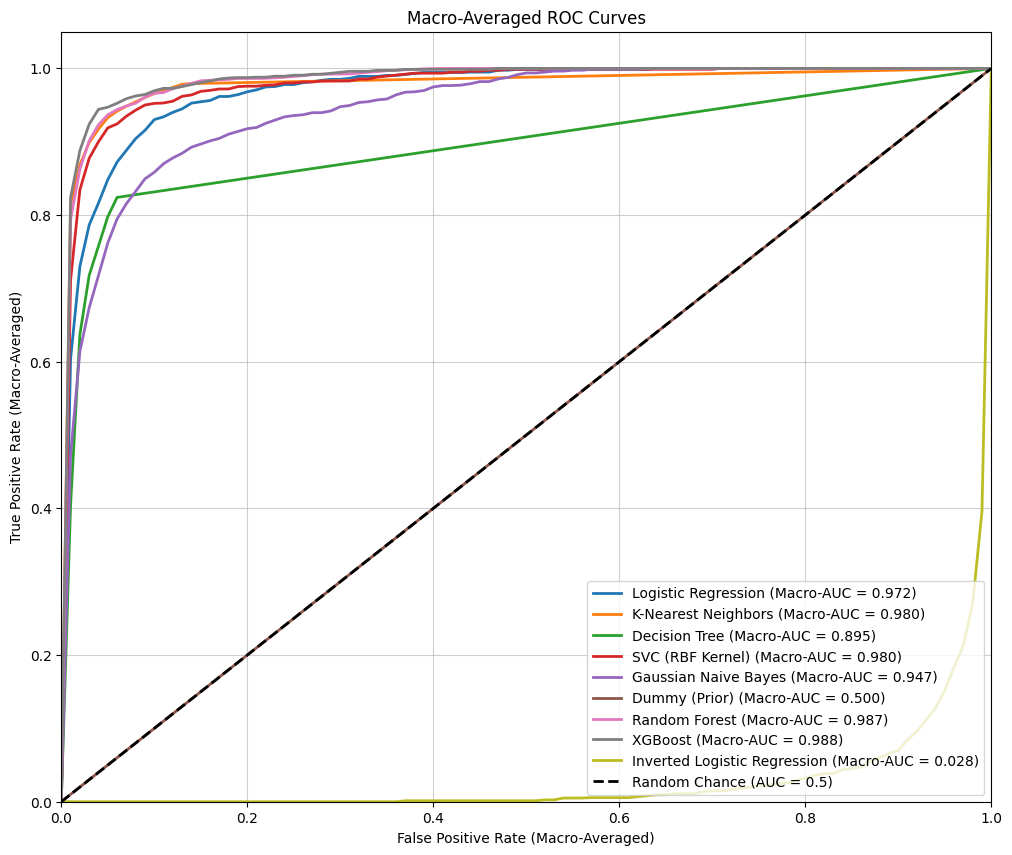

In [17]:
plt.figure(figsize=(12, 10))

for name, data in roc_plot_data.items():
    plt.plot(
        data['fpr'],
        data['tpr'],
        lw=2,
        label=f"{name} (Macro-AUC = {data['auc']:.3f})"
    )


plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Macro-Averaged)')
plt.ylabel('True Positive Rate (Macro-Averaged)')
plt.title('Macro-Averaged ROC Curves')
plt.legend(loc='lower right')
plt.grid(alpha=0.6)
plt.show()

### We can see Inverted Logistic regression curve is below AUC < 0.5 with an appaling AUC of 0.028. Both XGBoost and RandomForest outperform the previous best model KNN in terms of AUC, Lets check mAP also further

In [18]:
# Store results for plotting
prc_plot_data = {}

# Common recall grid for macro-averaging
common_recall = np.linspace(0, 1, 101)

for name, model in models.items():
    y_prob = models[name].predict_proba(X_test)
    current_model_classes = model.classes_
    if name == "XGBoost":
      current_model_classes = le.classes_
    # Align probabilities as done for ROC
    prob_df = pd.DataFrame(y_prob, columns=current_model_classes)
    prob_df = prob_df.reindex(columns=all_classes, fill_value=0)
    y_prob_aligned = prob_df.to_numpy()

    # Dictionary to store individual class precisions and APs
    precisions_per_class = []
    aps_per_class = []

    for i in range(n_classes):
        # Calculate PRC for class i vs. rest
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob_aligned[:, i])

        # Store AP
        aps_per_class.append(average_precision_score(y_test_bin[:, i], y_prob_aligned[:, i]))

        # Interpolate Precisions onto the common Recall grid
        # Note: We interpolate by first reversing both arrays, as recall is non-increasing
        prec_interp = np.interp(common_recall, recall[::-1], precision[::-1])
        precisions_per_class.append(prec_interp)

    # Calculate macro-average Precision and AP
    mean_precision = np.mean(precisions_per_class, axis=0)

    # Macro-AP is the average of individual APs
    macro_ap = np.mean(aps_per_class)

    # Store for plotting
    prc_plot_data[name] = {
        'recall': common_recall,
        'precision': mean_precision,
        'ap': macro_ap
    }

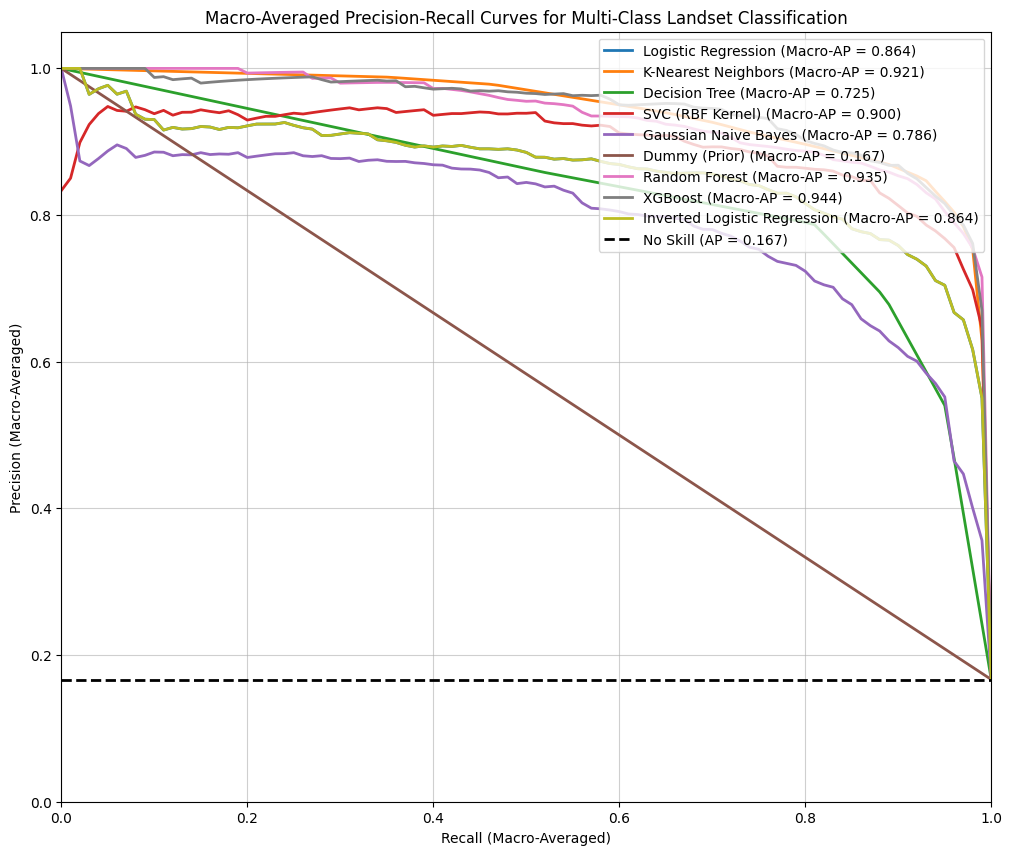

In [19]:
plt.figure(figsize=(12, 10))

for name, data in prc_plot_data.items():
    plt.plot(
        data['recall'],
        data['precision'],
        lw=2,
        label=f"{name} (Macro-AP = {data['ap']:.3f})"
    )

# Add a "no-skill" line, which is the prevalence of the positive class
# For macro-average, this is the average prevalence
no_skill = np.mean(np.sum(y_test_bin, axis=0) / len(y_test))
plt.axhline(y=no_skill, color='k', linestyle='--', lw=2, label=f'No Skill (AP = {no_skill:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Macro-Averaged)')
plt.ylabel('Precision (Macro-Averaged)')
plt.title('Macro-Averaged Precision-Recall Curves for Multi-Class Landset Classification')
plt.legend(loc='upper right')
plt.grid(alpha=0.6)
plt.show()

### Again both XGBoost and RandomForest outperform previous best KNN in terms of MAP also.

In [20]:
final_summary = {
    "Model": baseline_metrics["Model"],
    "Weighted F1-Score": baseline_metrics["Weighted F1-Score"],
    "Macro-AUC": [roc_plot_data[name]['auc'] for name in baseline_metrics["Model"]],
    "Macro-AP": [prc_plot_data[name]['ap'] for name in baseline_metrics["Model"]]
}

summary_df = pd.DataFrame(final_summary).sort_values(by="Weighted F1-Score", ascending=False)
print(summary_df.to_markdown(index=False, floatfmt=".4f"))

| Model                        |   Weighted F1-Score |   Macro-AUC |   Macro-AP |
|:-----------------------------|--------------------:|------------:|-----------:|
| XGBoost                      |              0.9110 |      0.9883 |     0.9440 |
| K-Nearest Neighbors          |              0.9094 |      0.9802 |     0.9215 |
| Random Forest                |              0.9058 |      0.9865 |     0.9352 |
| SVC (RBF Kernel)             |              0.8913 |      0.9797 |     0.8996 |
| Decision Tree                |              0.8481 |      0.8952 |     0.7246 |
| Logistic Regression          |              0.8421 |      0.9720 |     0.8638 |
| Gaussian Naive Bayes         |              0.7901 |      0.9473 |     0.7859 |
| Inverted Logistic Regression |              0.1698 |      0.0280 |     0.8638 |
| Dummy (Prior)                |              0.0919 |      0.5000 |     0.1667 |


### So we can conclude XGBoost is the best model for this dataset, providing far superior result than previous best KNN with AUC of 0.9883 and MAP of 0.9440